In [25]:
from pathlib import Path
import time
import torch
import numpy as np
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import tqdm
from torchid.dynonet.module.lti import SisoLinearDynamicalOperator
from torchid.dynonet.module.static import SisoStaticNonLinearity
import metrics

In [26]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [27]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Controls the input generation

In [28]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
batch_size = 32 # 256


# Compute settings
cuda_device = "cuda:0"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [29]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir / "ckpt_sim_wh.pt", map_location=device)
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [30]:
seq_len = cfg.seq_len_ctx + cfg.seq_len_new

In [31]:
# Create data loader
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=seq_len,
                    system_seed=system_seed, data_seed=data_seed, fixed_system=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [32]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx:, :]

In [51]:
def train_model(u, y, log=False, num_iter=100_000):
    
    # Model parameters
    order = 5
    
    # Learning parameters
    #num_iter = 100_000
    #num_iter_max = 1_000_000
    n_skip = 100
    lr = 1e-3
    
    # Setup dynoNet
    G1 = SisoLinearDynamicalOperator(order, order, n_k=1) 
    F_nl = SisoStaticNonLinearity(n_hidden=32, activation='tanh')
    G2 = SisoLinearDynamicalOperator(order+1, order)
    model = torch.nn.Sequential(G1, F_nl, G2)

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Loss function
    def closure():
        optimizer.zero_grad()

        # Simulate
        y_hat = model(u)

        # Compute fit loss
        err_fit = y[:, n_skip:, :] - y_hat[:, n_skip:, :]
        loss = torch.mean(err_fit**2)

        # Backward pas
        loss.backward()
        return loss


    # Training loop
    LOSS = []
    msg_freq = 1000
    start_time = time.time()
    for itr in range(0, num_iter):
            
        loss_train = optimizer.step(closure)

        LOSS.append(loss_train.item())
        if log:
            if itr % msg_freq == 0:
                with torch.no_grad():
                    RMSE = torch.sqrt(loss_train)
                print(f'Iter {itr} | Fit Loss {loss_train:.6f} | RMSE:{RMSE:.4f}')
    
    if log:
        train_time = time.time() - start_time
        print(f"\nTrain time: {train_time:.2f}")
    return model

In [52]:
time_start = time.time()

In [54]:
noise_std = 0.0
y_sim_full = []
for seq_idx in range(batch_size):
    print(f"Fitting sequence {seq_idx+1}")
    
    model = train_model(batch_u_ctx[[seq_idx]],
                        batch_y_ctx[[seq_idx]], num_iter=10_000)
    
    with torch.no_grad():
        y_sim_full.append(
            model(batch_u[[seq_idx]])
        )
        
batch_y_sim_full = torch.cat(y_sim_full)
batch_y_sim_new = batch_y_sim_full[:, cfg.seq_len_ctx:, :]

Fitting sequence 1
Fitting sequence 2
Fitting sequence 3
Fitting sequence 4
Fitting sequence 5
Fitting sequence 6
Fitting sequence 7
Fitting sequence 8
Fitting sequence 9
Fitting sequence 10
Fitting sequence 11
Fitting sequence 12
Fitting sequence 13
Fitting sequence 14
Fitting sequence 15
Fitting sequence 16
Fitting sequence 17
Fitting sequence 18
Fitting sequence 19
Fitting sequence 20
Fitting sequence 21
Fitting sequence 22
Fitting sequence 23
Fitting sequence 24
Fitting sequence 25
Fitting sequence 26
Fitting sequence 27
Fitting sequence 28
Fitting sequence 29
Fitting sequence 30
Fitting sequence 31
Fitting sequence 32


In [36]:
time_train = time.time() - time_start

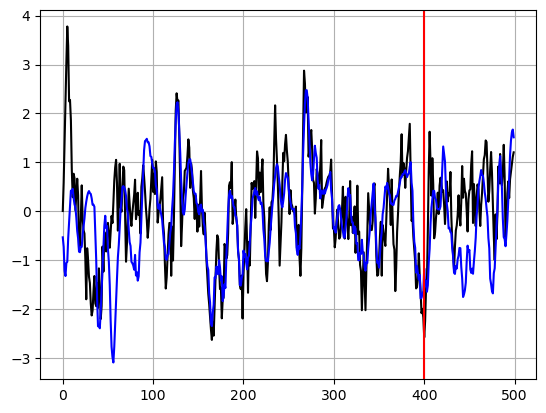

In [63]:
batch_idx = 3
plt.plot(batch_y[batch_idx], 'k')
plt.plot(batch_y_sim_full[batch_idx], 'b')
plt.grid()
plt.axvline(cfg.seq_len_ctx, color='red')

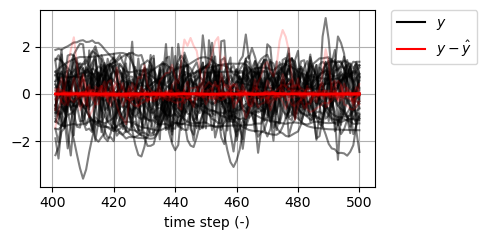

In [55]:
batch_sim_err = batch_y_new - batch_y_sim_new
t = np.arange(1, batch_u_new.shape[1]+1) + cfg.seq_len_ctx
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new.squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_batch_ml.pdf")

In [56]:
#%%
skip = 0
rmse_ml = metrics.rmse(batch_y_new.numpy(), batch_y_sim_new.numpy(), time_axis=1)

In [57]:
rmse_ml = np.nan_to_num(rmse_ml, copy=True, nan=np.nanmean(rmse_ml))

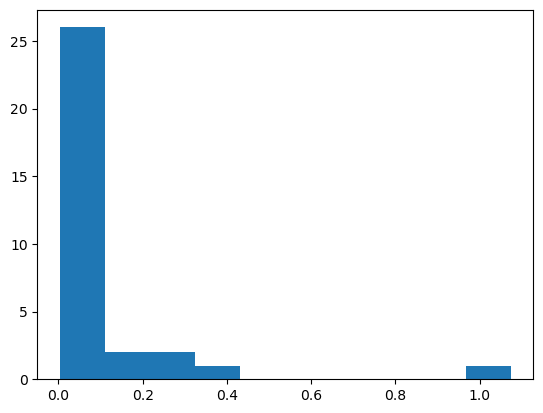

In [58]:
plt.hist(rmse_ml);

In [59]:
print(f'rmse: {rmse_ml.mean()}')

rmse: 0.09587809443473816


In [60]:
rmse_ml

array([[0.04551878],
       [0.31125584],
       [0.00370647],
       [1.0740486 ],
       [0.03322781],
       [0.3360031 ],
       [0.01801018],
       [0.00474854],
       [0.12928052],
       [0.02910161],
       [0.32333878],
       [0.03487578],
       [0.00944442],
       [0.00632136],
       [0.01588926],
       [0.02863612],
       [0.10673002],
       [0.03795959],
       [0.03512917],
       [0.0214694 ],
       [0.00818616],
       [0.06082053],
       [0.14538012],
       [0.01148279],
       [0.11044961],
       [0.00548774],
       [0.01764353],
       [0.04048095],
       [0.02110788],
       [0.008328  ],
       [0.00393394],
       [0.03010227]], dtype=float32)